In [1]:
from clipper_admin import ClipperConnection, DockerContainerManager
from clipper_admin.deployers import python as python_deployer

from xbos import get_client
from xbos.services.pundat import DataClient, make_dataframe
from xbos.services.hod import HodClient

import datetime
from datetime import timedelta
import json
import math
import numpy as np
import pandas as pd
import pytz
import requests
from scipy import spatial
%matplotlib inline


In [2]:
def json_deserialize_df(data):
    data = pd.DataFrame.from_dict(data)
    data.index = pd.to_datetime(data.index, unit='ms')
    data.index = data.index.tz_localize("US/Pacific")
    return data

def convert_timestamp(s):
    try:
        return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    except Exception as e:
        print e
        return ""
    
def hamming_distance(a, b):
    return np.count_nonzero(a != b)


def eucl_distance(a, b):
    return pd.np.linalg.norm(a - b)


def mins_in_day(timestamp):
    return timestamp.hour * 60 + timestamp.minute

def find_similar_days(training_data, now, observation_length, k, method=hamming_distance):
    min_time = training_data.index[0] + timedelta(minutes=observation_length)
    # Find moments in our dataset that have the same hour/minute and is_weekend() == weekend.
    print min_time
    selector = ((training_data.index.minute == now.minute) &
                (training_data.index.hour == now.hour) &
                (training_data.index > min_time))

    """
    if now.weekday() < 5:
        selector = (
            (training_data.index.minute == now.minute) &
            (training_data.index.hour == now.hour) &
            (training_data.index > min_time) &
            (training_data.index.weekday < 5)
        )
    else:
        selector = (
            (training_data.index.minute == now.minute) &
            (training_data.index.hour == now.hour) &
            (training_data.index > min_time) &
            (training_data.index.weekday >= 5)
        )
    """

    similar_moments = training_data[selector][:-1]
    print len(similar_moments)
    obs_td = timedelta(minutes=observation_length)

    similar_moments['Similarity'] = [
        method(
            training_data[(training_data.index >= now - obs_td) &
                            (training_data.index <= now)].get_values(),
            training_data[(training_data.index >= i - obs_td) &
                            (training_data.index <= i)].get_values()
        ) for i in similar_moments.index
        ]
    indexes = (similar_moments.sort_values('Similarity', ascending=True)
                .head(k).index)
    return indexes


def predict_list(input_list):
    result =[]
    for element in input_list:
        (data, now, similar_moments, prediction_time, resample_time) = json.loads(element)
        data = json_deserialize_df(json.loads(data))
        now = convert_timestamp(now)
        similar_moments = pd.read_json(similar_moments, typ='series')
        result.append(predict(data, now, similar_moments, prediction_time, resample_time).to_json())
    return result

def predict(data, now, similar_moments, prediction_time, resample_time):
    prediction = np.zeros((int(math.ceil(prediction_time/resample_time)) + 1, len(data.columns)))
    for i in similar_moments:
        prediction += (float(1.) / float(len(similar_moments))) * data[(data.index >= i) & (data.index <= i + timedelta(minutes=prediction_time))]
    print data[data.index == now]['occ']
    prediction[0] = data[data.index == now]['occ']
    time_index = pd.date_range(now, now+timedelta(minutes=prediction_time),freq='15T')
    return pd.DataFrame(data=prediction, index=time_index)


In [3]:
c = get_client()
archiver = DataClient(c)
hod = HodClient("ciee/hod",c)
occ_query = """SELECT ?occ ?uuid ?room WHERE {
?occ rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
?occ bf:uuid ?uuid .
?occ bf:isLocatedIn ?room .
?room rdf:type brick:Room .
};
"""
occ_query = """SELECT ?x ?room ?uuid WHERE {
    ?x rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
  	?x bf:isLocatedIn ?room .
    ?room bf:isPartOf bldg:SouthZone .
  	?x bf:uuid ?uuid .
};
"""
results = hod.do_query(occ_query)
uuids = [x['?uuid'] for x in results['Rows']]
rooms = [x['?room'] for x in results['Rows']]
mapping = dict(zip(uuids, rooms))
print results['Rows']
start = '"2017-08-19 07:00:00 PST"'
end = '"2017-09-20 07:00:00 PST"'
#start = 'now'
#end = 'now -30d'
dfs = make_dataframe(archiver.window_uuids(uuids, end, start, '15min', timeout=120))
for uid, df in dfs.items():
    if 'mean' in df.columns:
        df = df[['mean']]
    df.columns = ['occ']
    dfs[uid] = df.resample('15min').mean()
    
df = dfs.values()[0]
if len(dfs) > 1:
    for newdf in dfs.values()[1:]:
        df['occ'] += newdf['occ']
df['occ'] = 1*(df['occ']>0)

df.index = df.index.tz_localize('US/Pacific')

observation_length_addition = 4*60
k = 5
prediction_time = 24*60
resample_time = 15
now = datetime.datetime.now()
day = 1
hour = 0
minute = 0#resample_time * (now.minute / resample_time)
second = 0
now = datetime.datetime(year=now.year, month=now.month, day=day, hour=hour, minute=minute, second=second)
observation_length = mins_in_day(now) + observation_length_addition
similar_moments = find_similar_days(df, now, observation_length, k)

#predictions = predict(df, now, similar_moments, prediction_time, resample_time)

Saw [ucberkeley] archiver 8 seconds 158.385 ms ago
Saw [ciee/hod] HodDB 3 seconds 46.768 ms ago
[{'?room': 'R211', '?uuid': 'cab606d0-6d14-3aff-a0c2-e862ae297f22', '?x': 'hamilton_005e_pir'}, {'?room': 'R208', '?uuid': 'bdbbbf7c-21c3-3b61-8469-8516a8c666dd', '?x': 'hamilton_002b_pir'}, {'?room': 'R206', '?uuid': '497145c4-2087-3e89-9c8f-f54b87dfb016', '?x': 'hamilton_0027_pir'}, {'?uuid': '97ba99af-869b-3c43-94e3-93040c9bdd33', '?room': 'R208', '?x': 'enlighted_Sensor02d455_occupancy'}, {'?room': 'R208', '?uuid': 'c27adbad-b1b5-342c-91eb-a6709d365871', '?x': 'enlighted_Sensor02d454_occupancy'}, {'?room': 'R208', '?uuid': 'aefa14ef-a13a-355b-9b87-51511db7f541', '?x': 'enlighted_Sensor02d444_occupancy'}, {'?uuid': 'afed35be-ef70-341a-8bf4-565d815bfd90', '?room': 'R208', '?x': 'enlighted_Sensor02d438_occupancy'}, {'?room': 'R210', '?uuid': '989ed503-9aa2-310e-abd3-464f6169e175', '?x': 'hamilton_002a_pir'}, {'?room': 'R208', '?uuid': '2f5c888d-c0c6-33b4-9c30-d609f1e16fea', '?x': 'enlighted

In [4]:
predictions = predict_list([json.dumps([df.to_json(), now.strftime("%Y-%m-%d %H:%M:%S"), pd.Series(similar_moments).to_json(), prediction_time, resample_time])])
print predictions
predictions = json_deserialize_df(json.loads(predictions[0]))
#print predictions


2017-09-01 00:00:00-07:00    1
Name: occ, dtype: int64
['{"0":{"1504224000000":1.0,"1504224900000":1.0,"1504225800000":1.0,"1504226700000":0.8,"1504227600000":1.0,"1504228500000":1.0,"1504229400000":0.8,"1504230300000":0.8,"1504231200000":0.8,"1504232100000":1.0,"1504233000000":1.0,"1504233900000":1.0,"1504234800000":1.0,"1504235700000":1.0,"1504236600000":1.0,"1504237500000":1.0,"1504238400000":1.0,"1504239300000":1.0,"1504240200000":1.0,"1504241100000":1.0,"1504242000000":1.0,"1504242900000":1.0,"1504243800000":1.0,"1504244700000":1.0,"1504245600000":1.0,"1504246500000":1.0,"1504247400000":1.0,"1504248300000":1.0,"1504249200000":1.0,"1504250100000":1.0,"1504251000000":1.0,"1504251900000":1.0,"1504252800000":0.8,"1504253700000":1.0,"1504254600000":0.8,"1504255500000":0.8,"1504256400000":1.0,"1504257300000":0.8,"1504258200000":1.0,"1504259100000":0.8,"1504260000000":0.6,"1504260900000":0.8,"1504261800000":1.0,"1504262700000":0.8,"1504263600000":0.6,"1504264500000":0.6,"1504265400000":0

In [5]:
clipper_conn = ClipperConnection(DockerContainerManager())
clipper_conn.start_clipper()
python_deployer.deploy_python_closure(
    clipper_conn,
    name="occupancy",  # The name of the model in Clipper
    version=1,  # A unique identifier to assign to this model.
    input_type="strings",  # The type of data the model function expects as input
    func=predict_list # The model function to deploy
)
clipper_conn.register_application(
    name="occupancy-app",
    input_type="strings",
    default_output="-1",
    slo_micros=1000000000)
clipper_conn.link_model_to_app(app_name="occupancy-app", model_name="occupancy")

17-09-20:19:18:48 INFO     [docker_container_manager.py:96] Starting managed Redis instance in Docker
17-09-20:19:18:50 INFO     [clipper_admin.py:111] Clipper is running
17-09-20:19:18:50 INFO     [deployer_utils.py:42] Saving function to /tmp/clipper/tmpzwVKi1
17-09-20:19:18:52 INFO     [deployer_utils.py:63] Warning: Anaconda environment was either not found or exporting the environment failed. Your function will still be serialized and deployed, but may fail due to missing dependencies. In this case, please re-run inside an Anaconda environment. See http://clipper.ai/documentation/python_model_deployment/ for more information.
17-09-20:19:19:00 INFO     [deployer_utils.py:72] Supplied local modules
17-09-20:19:19:00 INFO     [deployer_utils.py:78] Serialized and supplied predict function
17-09-20:19:19:00 INFO     [python.py:166] Python closure saved
17-09-20:19:19:03 INFO     [clipper_admin.py:381] Building model Docker image with model data from /tmp/clipper/tmpzwVKi1
17-09-20:19

In [6]:
headers = {"Content-type": "application/json"}
serialized_string = json.dumps([df.to_json(), now.strftime("%Y-%m-%d %H:%M:%S"), pd.Series(similar_moments).to_json(), prediction_time, resample_time])

predictions = requests.post("http://localhost:1337/occupancy-app/predict", headers=headers, data=json.dumps({"input": serialized_string})).json()
print predictions
predictions = json_deserialize_df(predictions['output'])

print predictions

{u'default': False, u'output': {u'0': {u'1504260000000': 0.6, u'1504284300000': 0.0, u'1504310400000': 0.8, u'1504286100000': 0.0, u'1504271700000': 0.4, u'1504233000000': 1.0, u'1504243800000': 1.0, u'1504246500000': 1.0, u'1504277100000': 0.0, u'1504245600000': 1.0, u'1504282500000': 0.0, u'1504295100000': 0.0, u'1504261800000': 1.0, u'1504238400000': 1.0, u'1504255500000': 0.8, u'1504239300000': 1.0, u'1504241100000': 1.0, u'1504252800000': 0.8, u'1504276200000': 0.2, u'1504260900000': 0.8, u'1504278900000': 0.0, u'1504230300000': 0.8, u'1504293300000': 0.0, u'1504269900000': 0.4, u'1504254600000': 0.8, u'1504269000000': 0.2, u'1504224900000': 1.0, u'1504296900000': 0.0, u'1504274400000': 0.4, u'1504235700000': 1.0, u'1504244700000': 1.0, u'1504283400000': 0.0, u'1504242000000': 1.0, u'1504263600000': 0.6, u'1504253700000': 1.0, u'1504299600000': 0.2, u'1504292400000': 0.0, u'1504272600000': 0.2, u'1504305000000': 0.6, u'1504301400000': 0.2, u'1504233900000': 1.0, u'1504287900000': 

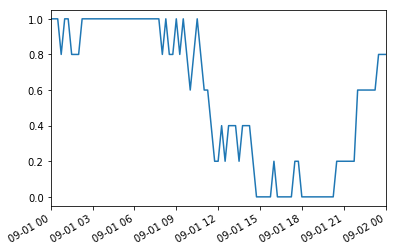

In [7]:
d = np.squeeze(predictions)
d.plot()

In [ ]:
clipper_conn.get_clipper_logs()

In [ ]:
clipper_conn.stop_all()